### Loading and examining data

In [147]:
import scipy.constants
import pandas as pd
import scipy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import time
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.utils import resample



import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from sklearn.base import clone

In [179]:
df = pd.read_csv('merged_data_sub_50.csv')
df.shape # before cleaning

(4262, 58)

In [180]:
thresh = len(df) * 0.05 # drop column if missing values in more than 95% of rows
df = df.dropna(thresh=thresh, axis = 1)
thresh2 = 20 # drop rows with < 20 non-missing
df = df.dropna(thresh=thresh2, axis=0)

In [181]:
df.shape

(4262, 58)

In [182]:
print(df.columns)

Index(['SEQN', 'RIDEXPRG', 'RIAGENDR', 'RIDAGEYR', 'RIDRETH2', 'SDMVPSU',
       'SDMVSTRA', 'WTMEC4YR', 'SDDSRVYR', 'RIDSTATR', 'LBXSAL', 'LBDSALSI',
       'LBXSATSI', 'LBXSASSI', 'LBXSAPSI', 'LBXSBU', 'LBDSBUSI', 'LBXSCA',
       'LBDSCASI', 'LBXSCH', 'LBDSCHSI', 'LBXSC3SI', 'LBXSGTSI', 'LBXSGL',
       'LBDSGLSI', 'LBXSIR', 'LBDSIRSI', 'LBXSLDSI', 'LBXSPH', 'LBDSPHSI',
       'LBXSTB', 'LBDSTBSI', 'LBXSTP', 'LBDSTPSI', 'LBXSTR', 'LBDSTRSI',
       'LBXSUA', 'LBDSUASI', 'LBDSCRSI', 'LBXSNASI', 'LBXSKSI', 'LBXSCLSI',
       'LBXSOSSI', 'LBXSGB', 'LBDSGBSI', 'LBXFSH', 'LBDFSHSI', 'LBXLH',
       'LBDLHSI', 'SSCYPC', 'WTSCY4YR', 'LBXSCR', 'eGFR', 'eGFR_no_race',
       'change_in_eGFR', 'eGFRcys', 'change_in_eGFR_cys', 'simulated_mGFR'],
      dtype='object')


In [183]:
# Further preparing the data 
# Drop irrelevant columns
columns_to_drop = ["SDMVPSU", "SDMVSTRA", "WTMEC4YR", "SDDSRVYR", "RIDSTATR", "WTSCY4YR"] # "eGFR", "eGFR_no_race", "change_in_eGFR"]
df = df.drop(columns=columns_to_drop)
# Encode categorical variables
label_encoders = {}
for column in ["RIAGENDR", "RIDRETH2", "RIDEXPRG"]:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column].astype(str))
    label_encoders[column] = le

# separating and printing shapes
labeled_data = df[df['simulated_mGFR'].notna()]
unlabeled_data = df[df['simulated_mGFR'].isna()]

X_labeled = labeled_data.drop(columns=['simulated_mGFR'])
y_labeled = labeled_data['simulated_mGFR']
X_unlabeled = unlabeled_data.drop(columns=['simulated_mGFR'])

print(X_labeled.shape, y_labeled.shape, X_unlabeled.shape)
print(X_labeled.columns)

(2131, 51) (2131,) (2131, 51)
Index(['SEQN', 'RIDEXPRG', 'RIAGENDR', 'RIDAGEYR', 'RIDRETH2', 'LBXSAL',
       'LBDSALSI', 'LBXSATSI', 'LBXSASSI', 'LBXSAPSI', 'LBXSBU', 'LBDSBUSI',
       'LBXSCA', 'LBDSCASI', 'LBXSCH', 'LBDSCHSI', 'LBXSC3SI', 'LBXSGTSI',
       'LBXSGL', 'LBDSGLSI', 'LBXSIR', 'LBDSIRSI', 'LBXSLDSI', 'LBXSPH',
       'LBDSPHSI', 'LBXSTB', 'LBDSTBSI', 'LBXSTP', 'LBDSTPSI', 'LBXSTR',
       'LBDSTRSI', 'LBXSUA', 'LBDSUASI', 'LBDSCRSI', 'LBXSNASI', 'LBXSKSI',
       'LBXSCLSI', 'LBXSOSSI', 'LBXSGB', 'LBDSGBSI', 'LBXFSH', 'LBDFSHSI',
       'LBXLH', 'LBDLHSI', 'SSCYPC', 'LBXSCR', 'eGFR', 'eGFR_no_race',
       'change_in_eGFR', 'eGFRcys', 'change_in_eGFR_cys'],
      dtype='object')


### Self training: trains regressor on labeled data, then predicts on unlabeled data. Adds confident predictions from unlabeled data to the labeled dataset. Repeat iteratively for defined number of iterations or until no further predictions are found. Vs. pseudolabeling: augments initial training set once with single pass through the test data-- can also be iterative but no measure of confidence?

In [184]:
# y_labeled = y_labeled.to_numpy()
X_train_labeled, X_test_labeled, y_train_labeled, y_test_labeled = train_test_split(X_labeled, y_labeled, test_size=0.2, random_state=42)
print(X_train_labeled.shape, X_test_labeled.shape)

(1704, 51) (427, 51)


In [185]:
# Hyperparameter tuning
param_grid = {
    'n_estimators': [25, 50, 100, 200, 400, 500],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
}
print("hi")

# XGBoost, grid search and 5 fold CV
xgb_regressor = xgb.XGBRegressor()
grid_search = RandomizedSearchCV(xgb_regressor, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_labeled, y_train_labeled)

best_xgb_regressor = grid_search.best_estimator_

hi


In [192]:
# reference: https://datawhatnow.com/pseudo-labeling-semi-supervised-learning/
def self_training_regressor(X_labeled, y_labeled, X_unlabeled, base_regressor, threshold=6, max_iter=10):
    model = clone(base_regressor)
    for iteration in range(max_iter):
        # Train the model (best_xbg_regression) on the labeled data
        model.fit(X_labeled, y_labeled)
        
        # Predict on the unlabeled data
        y_unlabeled_pred = model.predict(X_unlabeled)
        
        # naively get unlabeled predictions past a certain threshold/confidence to the labeled data 
        # for regression, closest to mean prediction?
        # confidence = np.abs(y_unlabeled_pred - np.mean(y_labeled)) / np.std(y_labeled)
        # confident_indices = np.where(confidence <= threshold)[0]

        # estimate variability in predictions using bootstrapping, then get predictions with low uncertainty 
        bootstrapped_predictions = []
        for _ in range(10):  # Bootstrap 10 samples
            X_boot, y_boot = resample(X_labeled, y_labeled)
            model.fit(X_boot, y_boot)
            bootstrapped_predictions.append(model.predict(X_unlabeled))
        
        uncertainty = np.std(bootstrapped_predictions, axis=0) # uncertainty for each prediction
        print(uncertainty)
        
        # Select confident predictions based on uncertainty
        confident_indices = np.where(uncertainty <= threshold)[0] # could decrease this threshold iteratively? 
        
        if len(confident_indices) == 0:
            print("Size of final labeled dataset: ", len(y_labeled), " (total is 4262 samples, 4176 training)") 
            break
        
        # Add the confident predictions to the labeled dataset
        X_labeled = pd.concat([X_labeled, X_unlabeled.iloc[confident_indices]], ignore_index=True)
        y_labeled = np.concatenate([y_labeled, y_unlabeled_pred[confident_indices]])
        
        # remove those same confident predictions from the unlabeled dataset
        X_unlabeled = X_unlabeled.drop(X_unlabeled.index[confident_indices]).reset_index(drop=True)
        
        print(f'Iteration {iteration+1}: Added {len(confident_indices)} confident predictions to the labeled dataset.')
    
    print("Size of final labeled dataset: ", len(y_labeled), " (total is 4262 samples, 4176 training)") 
    return model

# Apply self-training
print("X_train_labeled shape: ", X_train_labeled.shape)
print("y_train_labeled shape: ", y_train_labeled.shape)
print("X_unlabeled shape: ", X_unlabeled.shape)
print("X_test_labeled shape: ", X_test_labeled.shape)
final_model = self_training_regressor(X_train_labeled, y_train_labeled, X_unlabeled, best_xgb_regressor)


X_train_labeled shape:  (1704, 51)
y_train_labeled shape:  (1704,)
X_unlabeled shape:  (2131, 51)
X_test_labeled shape:  (427, 51)
[1.090488  1.4920754 2.558123  ... 1.6800563 1.6192673 4.7636175]
Iteration 1: Added 2116 confident predictions to the labeled dataset.
[5.7361345 4.5459576 1.5875643 5.9788113 2.2344198 2.2758524 6.093885
 6.528105  2.4571226 2.2061994 5.228936  2.1267202 7.152624  2.8918505
 3.3068624]
Iteration 2: Added 12 confident predictions to the labeled dataset.
[3.67594   4.329039  4.5353484]
Iteration 3: Added 3 confident predictions to the labeled dataset.
[]
Size of final labeled dataset:  3835  (total is 4262 samples, 4176 training)
Size of final labeled dataset:  3835  (total is 4262 samples, 4176 training)


In [193]:
# Evaluate on the validation set
y_val_pred = final_model.predict(X_test_labeled)
mse = mean_squared_error(y_test_labeled, y_val_pred)
print(f'Mean Squared Error on validation set: {mse}')

Mean Squared Error on validation set: 214.54485665515747


In [194]:
# Predict on the test set
y_pred = final_model.predict(X_test_labeled)
# Evaluate the model
r2 = r2_score(y_test_labeled, y_pred)
mae = mean_absolute_error(y_test_labeled, y_pred)

print(f'R-squared: {r2:.4f}')
print(f'Mean Absolute Error: {mae:.4f}')

R-squared: 0.6901
Mean Absolute Error: 11.6999


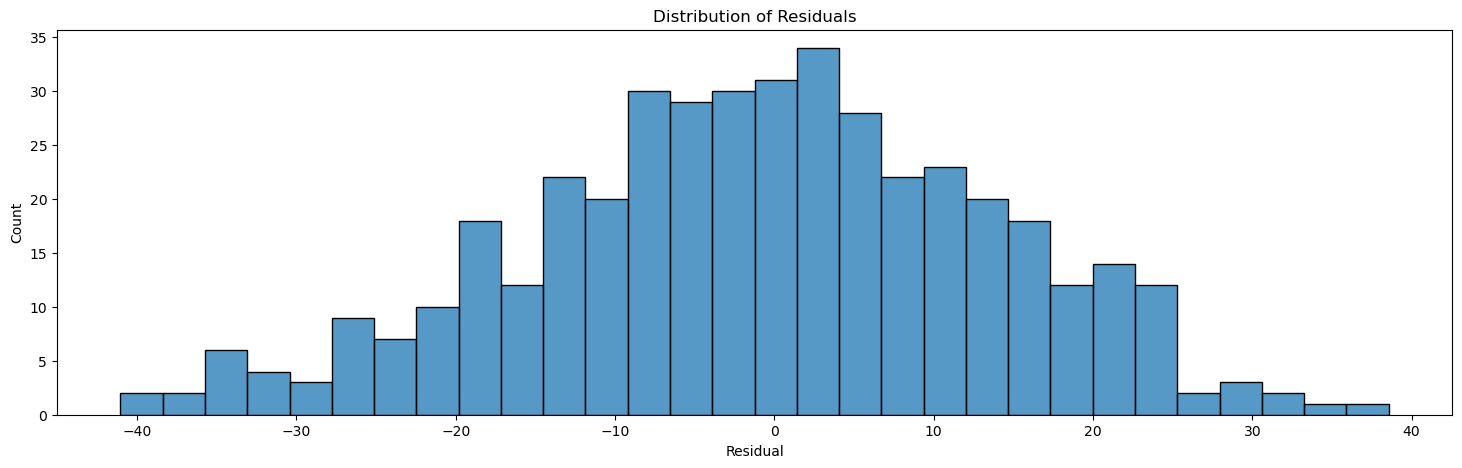

In [196]:
# Plotting residuals
xgb_preds = final_model.predict(X_test_labeled)
actuals = y_test_labeled
resids = xgb_preds - actuals

plt.figure(figsize=(18, 5))
sns.histplot(resids, bins=30, kde=False)
plt.title('Distribution of Residuals')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

571      65.483099
4010     28.877548
3392     65.876270
3313     94.168422
4111     99.472095
           ...    
3851     40.908418
1204     90.540221
4212    132.466219
378      75.432283
1322    101.017162
Name: simulated_mGFR, Length: 427, dtype: float64


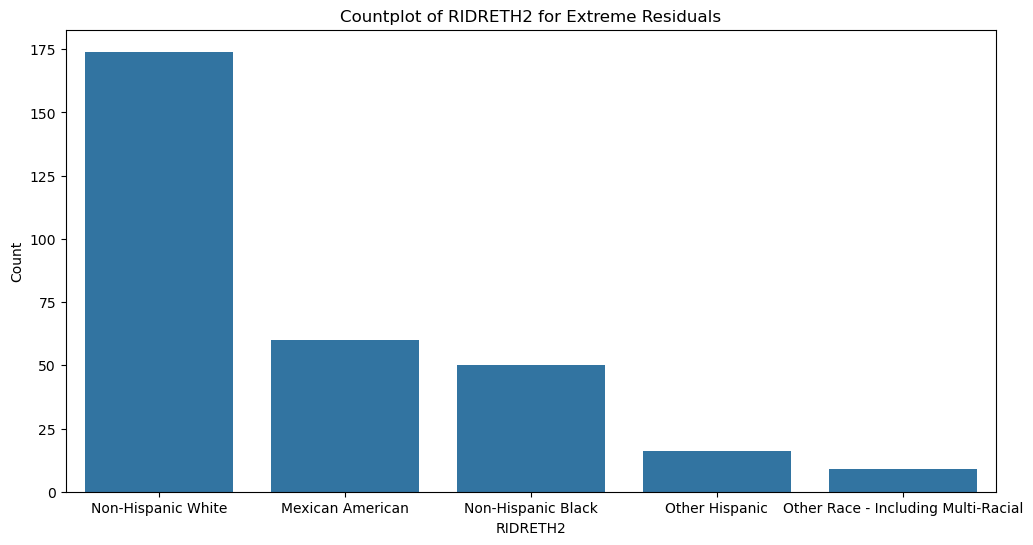

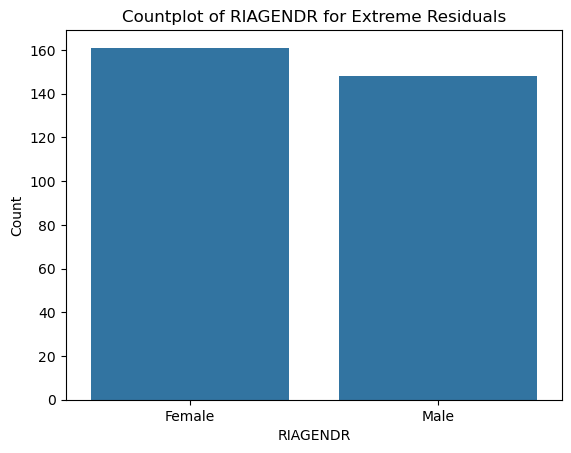

In [197]:
# turn y_test into Pandas series so can index
y_test_series = pd.Series(y_test_labeled)
print(y_test_series)

# Convert residuals to a pandas Series with the same index
resids_series = pd.Series(resids, index=y_test_series.index)
# print(resids_series)

# Filter the indices where residuals are less than -5 or greater than 5 
filtered_indices = resids_series[(resids_series < -5) | (resids_series > 5)].index
df['RIDRETH2_decoded'] = label_encoders['RIDRETH2'].inverse_transform(df['RIDRETH2'])
df['RIAGENDR_decoded'] = label_encoders['RIAGENDR'].inverse_transform(df['RIAGENDR'])
plt.figure(figsize=(12, 6))
sns.countplot(data=df.loc[filtered_indices], x='RIDRETH2_decoded')
plt.title('Countplot of RIDRETH2 for Extreme Residuals')
plt.xlabel('RIDRETH2')
plt.ylabel('Count')
plt.show()

sns.countplot(data=df.loc[filtered_indices], x='RIAGENDR_decoded')
plt.title('Countplot of RIAGENDR for Extreme Residuals')
plt.xlabel('RIAGENDR')
plt.ylabel('Count')
plt.show()


/var/folders/6p/6161x96942x8rv20mn8nby2r0000gn/T/ipykernel_76000/3458075820.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = varimps.Factor, y=varimps['Relative Importance'], palette='Paired');


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

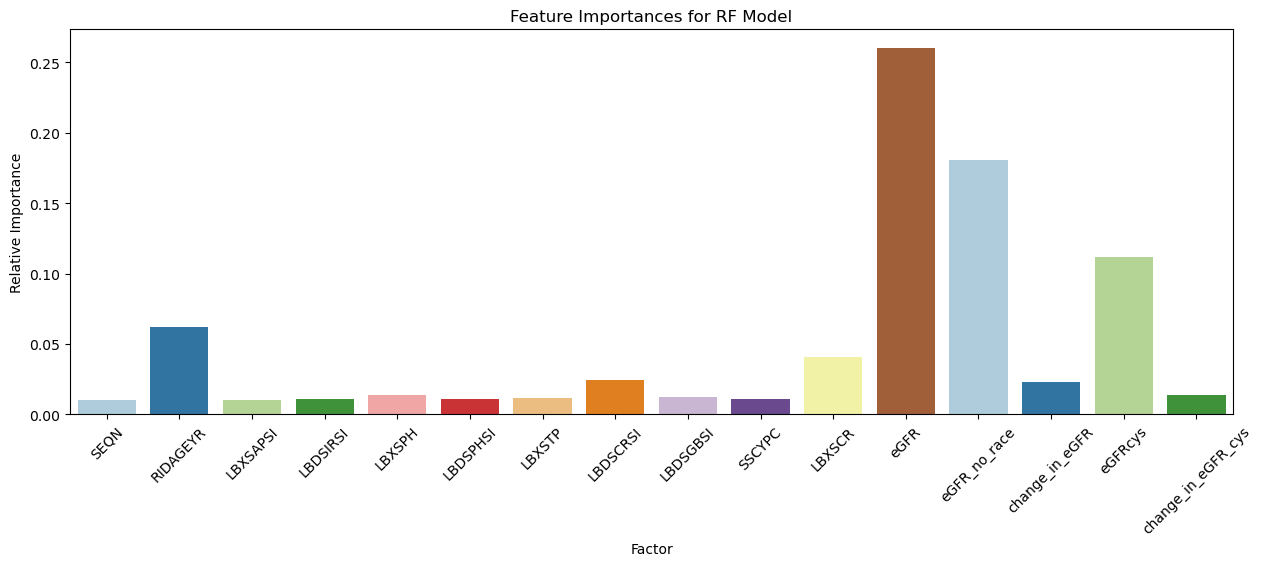

In [198]:
varimp = []
for name, score in zip(X_labeled.columns, final_model.feature_importances_):
    if score >= 0.01:
        varimp.append((name, score))

varimpdf = pd.DataFrame(varimp)

d = {'Factor': varimpdf[0], 'Relative Importance': varimpdf[1]}
varimps = pd.DataFrame(data=d)

plt.figure(figsize=(15,5))
plt.title("Feature Importances for RF Model")
sns.barplot(x = varimps.Factor, y=varimps['Relative Importance'], palette='Paired');
plt.xticks(rotation=45)

In [199]:
varimps.sort_values(by = 'Relative Importance', ascending=False)


,Factor,Relative Importance
11,eGFR,0.260333
12,eGFR_no_race,0.180916
14,eGFRcys,0.111674
1,RIDAGEYR,0.061763
10,LBXSCR,0.040557
7,LBDSCRSI,0.024738
13,change_in_eGFR,0.023214
15,change_in_eGFR_cys,0.013975
4,LBXSPH,0.013925
8,LBDSGBSI,0.012667


Text(0, 0.5, 'Actual Values')

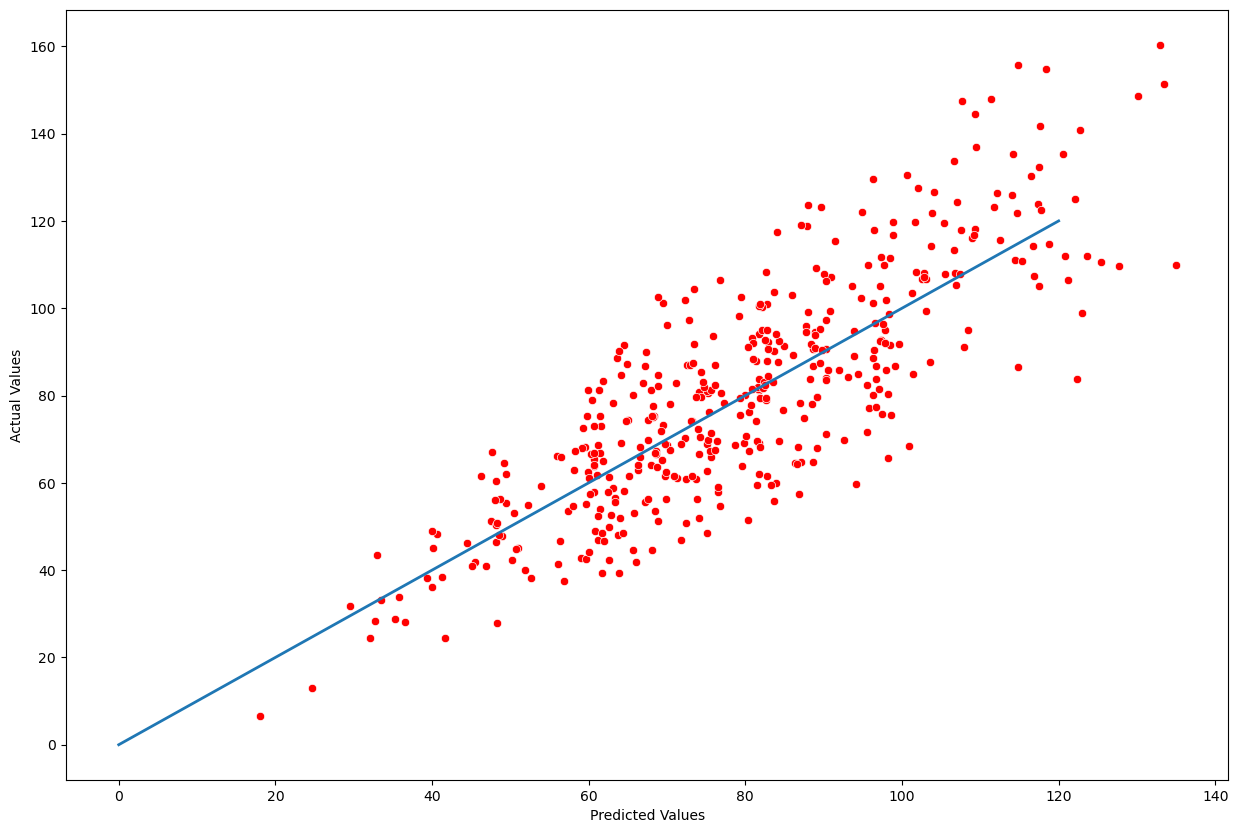

In [200]:
plt.figure(figsize=(15, 10));
sns.scatterplot(x=final_model.predict(X_test_labeled), y=y_test_labeled, color="red");
plt.plot([0, 120], [0, 120], linewidth=2);
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")